Не стал пересчитывать вложения с учетом инфляции, так как хотел посмотреть не только на первоначальные вложения, но и на распределение их по балансу.
В процентах боялся запутаться, но думаю что если учесть инфляцию, то результат просто станет лучше.

In [466]:
import os

import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV, SGDRegressor, LogisticRegressionCV, LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import preprocessing
from tqdm.notebook import tqdm
from autoviz.AutoViz_Class import AutoViz_Class
import datetime
from time import sleep, time
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [467]:
RANDOM_SEED = 42

In [468]:
# def na_info(ds: pd.DataFrame) -> pd.DataFrame:
#     arr = []
#     nans_cnt = ds.isna().sum()
#     for ind, row in tqdm(nans_cnt.items(), total=nans_cnt.shape[0]):
#         name = ind
#         if ind.startswith('ind_'):
#             name = buh_codes_dict[ind[4:8]]
#         arr.append([ind, name, row, round(row / data.shape[0] * 100, 2)])
#     return pd.DataFrame(arr, columns=['column', 'name', 'nan_cnt', 'nan_perc'])


def show_num_corr(df: pd.DataFrame, features: list = None, title: str ='Корреляция между данными'):
    '''
    Корреляция между числовыми признаками набора данных
    :param df: Набор данных
    :param features: признаки
    :param title: Заголовок карты
    :return: Корр карта признаков
    '''
    plt.figure(figsize=(16, 16))
    show_df =  df
    if features is not None:
        show_df = df[features]
    mask = np.triu(np.ones_like(show_df.corr(), dtype=bool))
    heatmap = sns.heatmap(show_df.corr(),
                          mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap = heatmap.set_title(title, fontdict={'fontsize': 18}, pad=16)
    return heatmap


def get_high_coreleted_features(df: pd.DataFrame, limit: float = 0.9, method: str = 'pearson') -> pd.DataFrame:
    '''
    Получить сильно скоррелированные признаки
    :param df: Набор данных
    :param limit: только те, корреляция которых превышает лимит
    :param method: метод вычисления корреляции
    :return: Наобор вида (признак1, признак2, коэфф корреляции)
    '''
    corr_ds = df.corr(method=method)
    corr_rows = []
    for ind_row, row in corr_ds.iterrows():
        for ind_col, cell in row.items():
            if abs(cell) > limit and ind_row != ind_col:
                if [ind_col, ind_row, cell] not in corr_rows:
                    corr_rows.append([ind_row, ind_col, cell])
    return pd.DataFrame(corr_rows, columns=['feature_1', 'feature_2', 'value'])


def outliers(df: pd.DataFrame, feature: str, iqrs: float = 1.5) -> pd.DataFrame:
    '''
    Получение выбросов по интерквартильному размаху
    :param df: Набор данных
    :param feature: Признак для которого ищем выбросы
    :param iqrs: Все что выходит за  IQR * iqrs
    :return: набор данных с выбросами
    '''
    # Интерквартильный размах
    perc25 = df[feature].quantile(0.25)
    perc75 = df[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - iqrs * IQR, perc75 + iqrs * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return df[(df[feature] < low) | (df[feature] > high)]


def first_look(s: pd.Series) -> None:
    '''
    EDA для признаков
    :param s: Колонка признака
    :return: None
    '''
    saved_format = pd.options.display.float_format
    pd.options.display.float_format = '{:.2f}'.format
    print('-' * 80)
    try:
        print('Название:', s.name)
        print('Тип данных:', s.dtype.type)
        print('Количество значений:', len(s))
        print('Количество уникальных значений:', s.nunique())
        print('Количество пропусков:', s.isna().sum())
        print(f'Процент пропусков: {round((s.isna().sum() / len(s)) * 100, 2)}%')
        print('Общие статистики:')
        print(s.describe())
        print('Топ 10 уникальных значений:')
        print(s.value_counts()[:10])
    except Exception as e:
        print('Ошибка:', str(e))
    print('-' * 80)
    pd.options.display.float_format = saved_format


def plot_feature_importances(fi, columns: list, num: int=20) -> None:
    '''
    График важности признаков для моделей с feature_importances
    :param fi: feature_importances
    :param columns: какие признаки смотрим
    :param num: сколько самых важных выводим
    :return: None
    '''
    plt.rcParams['figure.figsize'] = (10, 10)
    feat_importances = pd.Series(fi, index=columns)
    mean_imp = feat_importances.nlargest(num).mean()
    feat_colors = feat_importances.apply(lambda x: 'r' if x > mean_imp else 'b')
    feat_importances.nlargest(num).plot(kind='barh', title='Feature importance')


def show_roc_auc(y_test: list, probs: list) -> None:
    '''
    График ROC AUC
    :param y_test: Истенные значения
    :param probs: Предсказанные вероятности
    :return: None
    '''
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure(figsize=(12, 8))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()


def show_lr_Importance(model: LogisticRegression, features: list, n: int=20) -> None:
    '''
    График важности признаков для моделей с LR
    :param model: экземпляр LR
    :param features: какие признаки смотрим
    :param n: сколько самых важных выводим
    :return:
    '''
    lr_coef = pd.DataFrame(model.coef_.T, columns=['coefficient'], index=features)
    lr_coef = np.abs(lr_coef)
    lr_coef = lr_coef.sort_values(by='coefficient', ascending=False)
    f, ax = plt.subplots(1, 1, figsize=(16, 10))
    df4display = lr_coef.head(n)
    sns.barplot(x=df4display['coefficient'], y=df4display.index, palette="vlag", ax=ax)
    _ = ax.set_ylabel("Признак")
    _ = ax.set_title("Значимость признаков")


def show_confusion_matrix(y_pred: list, y_true: list) -> None:
    '''
    Матрица смежности для предсказаний классификатора
    :param y_pred: предсказанные значения
    :param y_true: истинные значения
    :return:
    '''
    plt.figure(figsize=(8, 8))
    c_matrix = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    heatmap = sns.heatmap(c_matrix, annot=True, cmap='BrBG', fmt='g', annot_kws={"fontsize": 18})
    heatmap = heatmap.set_title("Confusion matrix", fontdict={'fontsize': 18}, pad=16)


def print_clssification_metrix(y_pred: list, y_true: list):
    '''
    Метрики качества для классификатора
    :param y_pred:
    :param y_true:
    :return:
    '''
    print('Precision:', metrics.precision_score(y_pred, y_true))
    print('Recall:', metrics.recall_score(y_pred, y_true))
    print('F1-score:', metrics.f1_score(y_pred, y_true))


In [469]:
templ = pd.read_csv('data/df_moscow_all_upd.csv')
templ.head()

,inn,ogrn,main_okved,name,address,type,status,okved,date_reg,comments,...,founding_year,founding_month,name_okved,currency,inflation_by_2022,investments,inflation,total_profit,breaking_even,payback_time
0,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,67.0349,1.3200,20155.000000,1.0538,0,0,-1
1,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,58.3529,1.2527,21239.338735,1.0252,0,0,-1
2,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,62.7078,1.2218,21774.570269,1.0427,0,0,-1
3,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,64.7362,1.1718,22704.345558,1.0305,0,0,-1
4,7721452574,1167700052233,85.22,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,"109542, г. Москва, пр-кт Рязанский, 86/1",некоммерческая унитарная,действующая,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",2016-02-15,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",...,2016,2,Образование высшее,72.1464,1.1371,23396.829332,1.0491,0,0,-1


In [470]:
dollar = templ.groupby('year')['currency'].mean().to_dict()
dollar

{2011: 29.387400000000003,
 2012: 31.093000000000004,
 2013: 31.848000000000003,
 2014: 38.4217,
 2015: 60.9579,
 2016: 67.0349,
 2017: 58.3529,
 2018: 62.7078,
 2019: 64.7362,
 2020: 72.1464,
 2021: 73.6541}

In [471]:
data = pd.read_csv('data/data-2012.csv')
curr_ind = [c for c in data.columns if c.startswith('ind_') and c.endswith('3')]
data['year'] = 2012
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5776 entries, 0 to 5775
Columns: 268 entries, name to year
dtypes: float64(2), int64(265), object(1)
memory usage: 11.8+ MB


In [472]:
col4 = [c[:-1] for c in data.columns if c.startswith('ind_') and  c.endswith('4')]
data2011 = data[['org_inn', 'year', 'okved', 'name','subject_rf', 'type', 'okopf', 'okfs', 'measure']]
for col in curr_ind:
    if col[:-1] in col4:
        data2011[col] = data[col[:-1] + '4']
    else:
        data2011[col] = 0
data2011['year'] = 2011
data2011.head()

,org_inn,year,okved,name,subject_rf,type,okopf,okfs,measure,ind_11103,...,ind_63213,ind_63223,ind_63233,ind_63243,ind_63253,ind_63263,ind_63303,ind_63503,ind_63003,ind_64003
0,4824053865,2011,72.20,"Общество с ограниченной ответственностью ""Бизнес - технологии""",48.0,1,65,16,384,0,...,0,0,0,0,0,0,0,0,0,0
1,2508090520,2011,63.11,"Закрытое акционерное общество ""Находкинский Международный Терминал""",NaN,2,67,34,384,0,...,0,0,0,0,0,0,0,0,0,0
2,7802794520,2011,63.12,"Общество с ограниченной ответственностью ""Волховнефтепродукт""",78.0,1,65,16,384,0,...,0,0,0,0,0,0,0,0,0,0
3,7717029782,2011,55.10,"ОТКРЫТОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО ""ГОСТИНИЦА ""ЗВЕЗДНАЯ""",77.0,2,47,34,384,0,...,0,0,0,0,0,0,0,0,0,0
4,7723841914,2011,72.20,"Общество с ограниченной ответственностью ""Э-КОМ РУС""",NaN,2,65,34,384,0,...,0,0,0,0,0,0,0,0,0,0


In [473]:
data = data2011

In [474]:
files = [f for f in os.listdir('data/') if f.startswith('data-')]
# files.remove('data-2012.csv')
for file in files:
    data_part = pd.read_csv(f'data/{file}')
    data_part['year'] = int(file[5:9])
    data = pd.concat([data, data_part])
data = data[['org_inn', 'year', 'okved', 'name','subject_rf', 'type', 'okopf', 'okfs', 'measure'] + curr_ind]
data.columns = ['inn', 'year', 'main_okved', 'name', 'subject_rf', 'type', 'okopf', 'okfs', 'measure'] + [c[:-1]for c in curr_ind]
data.head()

,inn,year,main_okved,name,subject_rf,type,okopf,okfs,measure,ind_1110,...,ind_6321,ind_6322,ind_6323,ind_6324,ind_6325,ind_6326,ind_6330,ind_6350,ind_6300,ind_6400
0,4824053865,2011,72.2,"Общество с ограниченной ответственностью ""Бизнес - технологии""",48.0,1,65,16,384,0,...,0,0,0,0,0,0,0,0,0,0
1,2508090520,2011,63.11,"Закрытое акционерное общество ""Находкинский Международный Терминал""",NaN,2,67,34,384,0,...,0,0,0,0,0,0,0,0,0,0
2,7802794520,2011,63.12,"Общество с ограниченной ответственностью ""Волховнефтепродукт""",78.0,1,65,16,384,0,...,0,0,0,0,0,0,0,0,0,0
3,7717029782,2011,55.1,"ОТКРЫТОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО ""ГОСТИНИЦА ""ЗВЕЗДНАЯ""",77.0,2,47,34,384,0,...,0,0,0,0,0,0,0,0,0,0
4,7723841914,2011,72.2,"Общество с ограниченной ответственностью ""Э-КОМ РУС""",NaN,2,65,34,384,0,...,0,0,0,0,0,0,0,0,0,0


In [475]:
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510887 entries, 0 to 149789
Data columns (total 140 columns):
 #    Column      Non-Null Count   Dtype  
---   ------      --------------   -----  
 0    inn         510887 non-null  int64  
 1    year        510887 non-null  int64  
 2    main_okved  510887 non-null  object 
 3    name        510887 non-null  object 
 4    subject_rf  234534 non-null  float64
 5    type        510887 non-null  int64  
 6    okopf       510887 non-null  int64  
 7    okfs        510887 non-null  int64  
 8    measure     510887 non-null  int64  
 9    ind_1110    510887 non-null  int64  
 10   ind_1120    510887 non-null  int64  
 11   ind_1130    510887 non-null  int64  
 12   ind_1140    510887 non-null  int64  
 13   ind_1150    510887 non-null  int64  
 14   ind_1160    510887 non-null  int64  
 15   ind_1170    510887 non-null  int64  
 16   ind_1180    510887 non-null  int64  
 17   ind_1190    510887 non-null  int64  
 18   ind_1100    510887 non

In [476]:
# Сразу типмизируем, чтоб не путаться
data['inn'] = data['inn'].astype(str)
data['main_okved'] = data['main_okved'].astype(str)
data['name'] = data['name'].astype(str)
data['type'] = data['type'].astype(int)
data['year'] = data['year'].astype(int)
data['subject_rf'] = data['subject_rf'].fillna('99').astype(int).astype(str)
ind_columns = [c for c in data.columns if c.startswith('ind_')]
data[ind_columns] = data[ind_columns].astype(float)
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510887 entries, 0 to 149789
Data columns (total 140 columns):
 #    Column      Non-Null Count   Dtype  
---   ------      --------------   -----  
 0    inn         510887 non-null  object 
 1    year        510887 non-null  int64  
 2    main_okved  510887 non-null  object 
 3    name        510887 non-null  object 
 4    subject_rf  510887 non-null  object 
 5    type        510887 non-null  int64  
 6    okopf       510887 non-null  int64  
 7    okfs        510887 non-null  int64  
 8    measure     510887 non-null  int64  
 9    ind_1110    510887 non-null  float64
 10   ind_1120    510887 non-null  float64
 11   ind_1130    510887 non-null  float64
 12   ind_1140    510887 non-null  float64
 13   ind_1150    510887 non-null  float64
 14   ind_1160    510887 non-null  float64
 15   ind_1170    510887 non-null  float64
 16   ind_1180    510887 non-null  float64
 17   ind_1190    510887 non-null  float64
 18   ind_1100    510887 non

In [477]:
data.head()

,inn,year,main_okved,name,subject_rf,type,okopf,okfs,measure,ind_1110,...,ind_6321,ind_6322,ind_6323,ind_6324,ind_6325,ind_6326,ind_6330,ind_6350,ind_6300,ind_6400
0,4824053865,2011,72.2,"Общество с ограниченной ответственностью ""Бизнес - технологии""",48,1,65,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2508090520,2011,63.11,"Закрытое акционерное общество ""Находкинский Международный Терминал""",99,2,67,34,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7802794520,2011,63.12,"Общество с ограниченной ответственностью ""Волховнефтепродукт""",78,1,65,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7717029782,2011,55.1,"ОТКРЫТОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО ""ГОСТИНИЦА ""ЗВЕЗДНАЯ""",77,2,47,34,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7723841914,2011,72.2,"Общество с ограниченной ответственностью ""Э-КОМ РУС""",99,2,65,34,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [478]:
# Год когда появилась первая отчетность компании
first_year = data.groupby(['inn'])['year'].min().rename('first_year')
data.drop('first_year', axis=1, inplace=True, errors='ignore')
data = data.join(first_year, on='inn')
data.head()

,inn,year,main_okved,name,subject_rf,type,okopf,okfs,measure,ind_1110,...,ind_6322,ind_6323,ind_6324,ind_6325,ind_6326,ind_6330,ind_6350,ind_6300,ind_6400,first_year
0,4824053865,2011,72.2,"Общество с ограниченной ответственностью ""Бизнес - технологии""",48,1,65,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
1,2508090520,2011,63.11,"Закрытое акционерное общество ""Находкинский Международный Терминал""",99,2,67,34,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
2,7802794520,2011,63.12,"Общество с ограниченной ответственностью ""Волховнефтепродукт""",78,1,65,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
3,7717029782,2011,55.1,"ОТКРЫТОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО ""ГОСТИНИЦА ""ЗВЕЗДНАЯ""",77,2,47,34,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
4,7723841914,2011,72.2,"Общество с ограниченной ответственностью ""Э-КОМ РУС""",99,2,65,34,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011


In [479]:
# Год когда была последняя отчетность компании
last_year = data.groupby(['inn'])['year'].max().rename('last_year')
data.drop('last_year', axis=1, inplace=True, errors='ignore')
data = data.join(last_year, on='inn')
data.head()

,inn,year,main_okved,name,subject_rf,type,okopf,okfs,measure,ind_1110,...,ind_6323,ind_6324,ind_6325,ind_6326,ind_6330,ind_6350,ind_6300,ind_6400,first_year,last_year
0,4824053865,2011,72.2,"Общество с ограниченной ответственностью ""Бизнес - технологии""",48,1,65,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011,2014
1,2508090520,2011,63.11,"Закрытое акционерное общество ""Находкинский Международный Терминал""",99,2,67,34,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011,2012
2,7802794520,2011,63.12,"Общество с ограниченной ответственностью ""Волховнефтепродукт""",78,1,65,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011,2015
3,7717029782,2011,55.1,"ОТКРЫТОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО ""ГОСТИНИЦА ""ЗВЕЗДНАЯ""",77,2,47,34,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011,2018
4,7723841914,2011,72.2,"Общество с ограниченной ответственностью ""Э-КОМ РУС""",99,2,65,34,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011,2015


In [480]:
# for col in [c for c in data.columns if c.startswith('ind_')]:
#     data[col] = data[col] / data['currency']

In [481]:
# Берем все признаки из самого раннего года организации - объединяем с основным набором
additional_features = [c for c in data.columns if c.startswith('ind_')]
additional_features.remove('ind_1600')
#additional_features.remove('ind_2400')
investments = data.sort_values(by=['inn', 'year']).groupby('inn').first()[['year', 'ind_1600'] + additional_features]
investments.columns = ['inv_year', 'inv_sum'] + ['inv_' + x for x in additional_features]
data.drop(investments.columns, axis=1, inplace=True, errors='ignore')
data = data.join(investments, on=['inn'])
data[['inn', 'year'] + investments.columns.tolist()].head() #.sort_values(by=['inn', 'year']).head()

,inn,year,inv_year,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
0,4824053865,2011,2011,116.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2508090520,2011,2011,153192.0,0.0,0.0,0.0,0.0,24146.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7802794520,2011,2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7717029782,2011,2011,75169.0,0.0,0.0,0.0,0.0,35523.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7723841914,2011,2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [482]:
data.loc[data['inv_sum'] <= 0, ['inv_sum', 'inn', 'year']]

,inv_sum,inn,year
2,0.0,7802794520,2011
4,0.0,7723841914,2011
21,0.0,7723846581,2011
41,0.0,7806479367,2011
45,0.0,7717732610,2011
...,...,...,...
149784,0.0,7802850573,2018
149786,0.0,4227001704,2018
149787,0.0,6324023922,2018
149788,0.0,4704032609,2018


In [483]:
# Накопительно вычисляем сумму прибыли организации по годам - объединяем с набором
profit = data.sort_values(by=['inn', 'year']).groupby('inn').cumsum()['ind_2400']
profit.name = 'profit'
data.drop(['profit'], axis=1, inplace=True, errors='ignore')
data = data.join(profit)
data[['inn', 'year', 'ind_2400', 'profit'] + investments.columns.tolist()].sort_values(by=['inn', 'year']).head()

,inn,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
5477,1001002620,2013,24047.0,24047.0,2013,40522.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5477,1001002620,2013,24047.0,0.0,2013,40522.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5477,1001002620,2013,24047.0,96.0,2013,40522.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5477,1001002620,2013,24047.0,6406.0,2013,40522.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5477,1001002620,2013,24047.0,1006.0,2013,40522.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [484]:
data.sort_values(by=['inn', 'year']).groupby('inn').last()[['year', 'ind_2400', 'profit'] + investments.columns.tolist()].head()

,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
inn,,,,,,,,,,,,,,,,,,,,,
1001002620,2015,8933.0,0.0,2013,40522.0,0.0,0.0,0.0,0.0,4819.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001004137,2017,-116.0,0.0,2017,101.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001004176,2016,0.0,-495.0,2016,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001004377,2018,31.0,26.0,2016,71.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001007610,2018,1897.0,712.0,2016,106.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [485]:
features = ['year', 'ind_2400', 'profit', 'result',] + investments.columns.tolist()

In [486]:
# Формируем результат деятельности организации за год как разницу между первоначальным вложением и прбылью после налогов
data['result'] = data['inv_sum'] - data['profit']
data.sample(2)

,inn,year,main_okved,name,subject_rf,type,okopf,okfs,measure,ind_1110,...,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400,profit,result
14882,5403348086,2013,72.2,"Общество с ограниченной ответственностью ""ГосКомСофт""",99,2,12165,16,384,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2429.0
128778,9204561924,2018,56.10.1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ГАРАНТИЯ КАЧЕСТВА""",92,1,12300,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,450.0


In [487]:
# Объединяем во временный набор последние записи об организации и записи где организаци вышла в 0 плюс
# затем берем ту что была раньше
temp = pd.concat([data.sort_values(by=['inn', 'year']).groupby('inn').last(),
           data[data['result'] <= 0].sort_values(by=['inn', 'year']).groupby('inn').first()]).reset_index()
temp = temp.sort_values(by=['inn', 'year']).groupby(['inn']).first().reset_index()
temp.sample(2) #[['inn'] + features]

,inn,year,main_okved,name,subject_rf,type,okopf,okfs,measure,ind_1110,...,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400,profit,result
110670,5751034186,2018,71.1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ПРОЕКТНОЕ АГЕНТСТВО ""СПУТНИК""",99,1,65,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168315,7705659638,2016,60.10,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЕВРОМЕДИА""",77,1,65,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4898.0,-3876.0


In [488]:
# Формироуем таргет как разницу межу годом выхода в плюс и годом инвестирования или -1 если так и не вашли в плюс
temp['target'] = temp.apply(lambda row: -1 if row['result'] > 0 else row['year'] - row['inv_year'], axis=1)
temp.sample(2)

,inn,year,main_okved,name,subject_rf,type,okopf,okfs,measure,ind_1110,...,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400,profit,result,target
178750,7715184528,2018,58.11,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""МАШИНОСТРОЕНИЕ-ПОЛЕТ""",77,1,65,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,497.0,-1
40347,2635212587,2017,85.41,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЦЕНТР-ЮГ""",26,1,12300,16,384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2344.0,-934.0,0


In [489]:
# В рабочий набор берем только коммерческие организации
work_df = temp.loc[(temp['type'] > 0) & (temp['measure'] == 384), ['inn', 'main_okved', 'inv_sum', 'target', 'subject_rf', 'year', 'first_year', 'last_year'] + ['inv_' + x for x in additional_features]]
work_df.head()

,inn,main_okved,inv_sum,target,subject_rf,year,first_year,last_year,inv_ind_1110,inv_ind_1120,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
0,1001002620,63.11,40522.0,-1,99,2015,2013,2015,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1001004137,56.10.1,101.0,-1,99,2017,2017,2017,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1001004176,85.41,0.0,-1,10,2016,2016,2016,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1001004377,91.02,71.0,0,99,2016,2016,2018,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1001007610,93.2,106.0,0,10,2016,2016,2018,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [490]:
work_df_target = work_df['target']
work_df_target.unique()

array([-1,  0,  2,  1,  3,  4,  6,  5,  7])

### EDA

In [491]:
for f in work_df.columns:
   first_look(work_df[f])

--------------------------------------------------------------------------------
Название: inn
Тип данных: <class 'numpy.object_'>
Количество значений: 219824
Количество уникальных значений: 219824
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count         219824
unique        219824
top       1001002620
freq               1
Name: inn, dtype: object
Топ 10 уникальных значений:
1001002620    1
7606088824    1
7606089698    1
7606093655    1
7606093750    1
7606094031    1
7606094169    1
7606094225    1
7606094257    1
7606094352    1
Name: inn, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Название: main_okved
Тип данных: <class 'numpy.object_'>
Количество значений: 219824
Количество уникальных значений: 68
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count     219824
unique        68
top        94.99
freq       40401

### Feature engineering

In [492]:
work_df = work_df[work_df['inv_sum'] > 0]

In [493]:
# Привести все индексы к доллару
work_df['dollar'] = work_df['year'].apply(lambda x: dollar[x])
for feature in ['inv_sum'] + ['inv_' + x for x in additional_features]:
    work_df[feature] = work_df[feature] / work_df['dollar']

In [494]:
# for feature in ['inv_sum'] + ['inv_' + x for x in additional_features]:
#     work_df[feature] = work_df.apply(lambda row: row[feature] / dollar[row['year']], axis=1)

<AxesSubplot:>

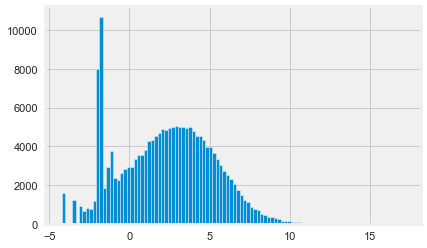

In [495]:
np.log(work_df['inv_sum']).hist(bins=100)

In [496]:
work_df['inv_sum'] = np.log(work_df['inv_sum'])

In [497]:
# for feature in ['inv_sum'] + ['inv_' + x for x in additional_features]:
#     work_df[feature] = work_df.apply(lambda row: row[feature] / dollar[row['year']], axis=1)

### Первая модель - LR

In [498]:
# Формируем X
# Масштабируем числовые признаки
X = pd.DataFrame([], index=work_df.index)
X[['inv_sum'] + ['inv_' + x for x in additional_features]] = preprocessing.StandardScaler().fit_transform(work_df[['inv_sum'] + ['inv_' + x for x in additional_features]])
X.sample(2)

,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,inv_ind_1170,inv_ind_1180,inv_ind_1190,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
148890,0.674714,-0.003274,-0.012997,-0.004607,-0.003929,-0.011082,-0.00708,-0.003453,-0.019513,-0.012851,...,-0.01636,-0.009458,-0.013228,-0.017641,-0.011358,-0.015257,-0.008444,-0.004353,-0.009859,-0.011399
72154,2.102269,-0.003279,-0.012997,-0.004607,-0.003929,-0.011082,-0.00708,-0.003453,-0.019513,0.450579,...,-0.01636,-0.009458,-0.013228,-0.017641,-0.011358,-0.015257,-0.008444,-0.004353,-0.009859,-0.011399


In [499]:
# Кодируем категориальные признаки
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved', 'subject_rf']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved', 'subject_rf']]).astype(int)
X.sample(2)

,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,inv_ind_1170,inv_ind_1180,inv_ind_1190,...,x1_79,x1_8,x1_83,x1_86,x1_87,x1_89,x1_9,x1_91,x1_92,x1_99
37502,-0.308641,-0.003279,-0.012997,-0.004607,-0.003929,-0.011082,-0.00708,-0.003453,-0.019513,-0.012851,...,0,0,0,0,0,0,0,0,0,1
174881,-0.526350,-0.003279,-0.012997,-0.004607,-0.003929,-0.011082,-0.00708,-0.003453,-0.019513,-0.012851,...,0,0,0,0,0,0,0,0,0,1


In [500]:
# В таргет берем только признак окупиться/не окупится
y = (work_df['target'] != -1).astype(int)
y.unique()

array([0, 1])

In [501]:
# Бъем на трейн - тест
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((183907, 284), (183907,), (147125, 284), (147125,), (36782, 284), (36782,))

In [502]:
# Теперь моделька
lr = LogisticRegressionCV(Cs=10, random_state=RANDOM_SEED, class_weight='balanced')
lr.fit(X_train, y_train)
y_prob = lr.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.7359578710897888

В принципе результат не плохой - можно работать дальше

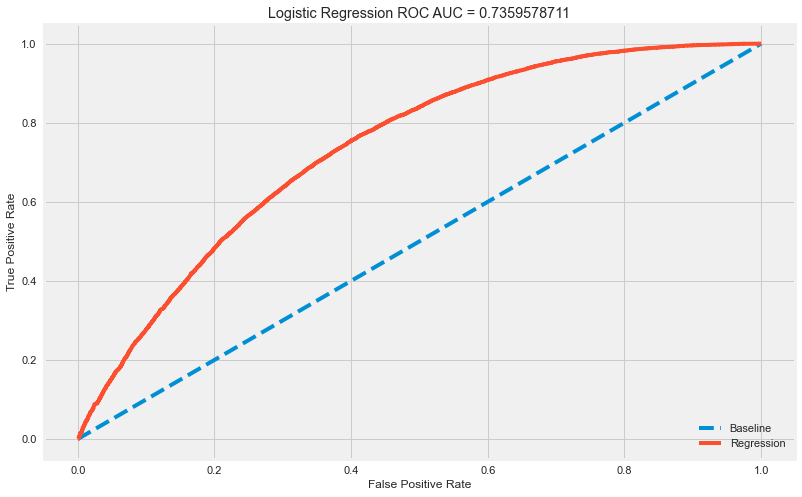

In [503]:
show_roc_auc(y_valid, y_prob[:, 1])

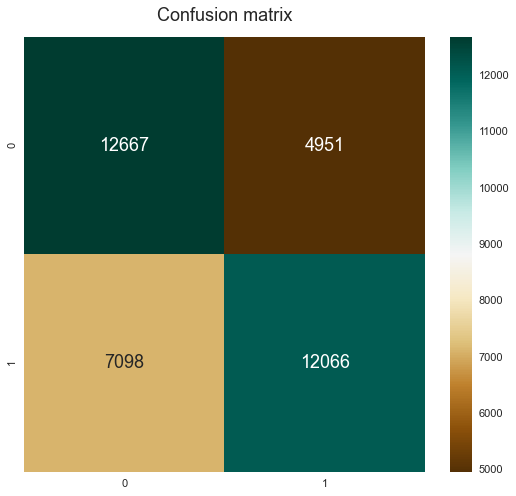

In [504]:
y_pred = lr.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

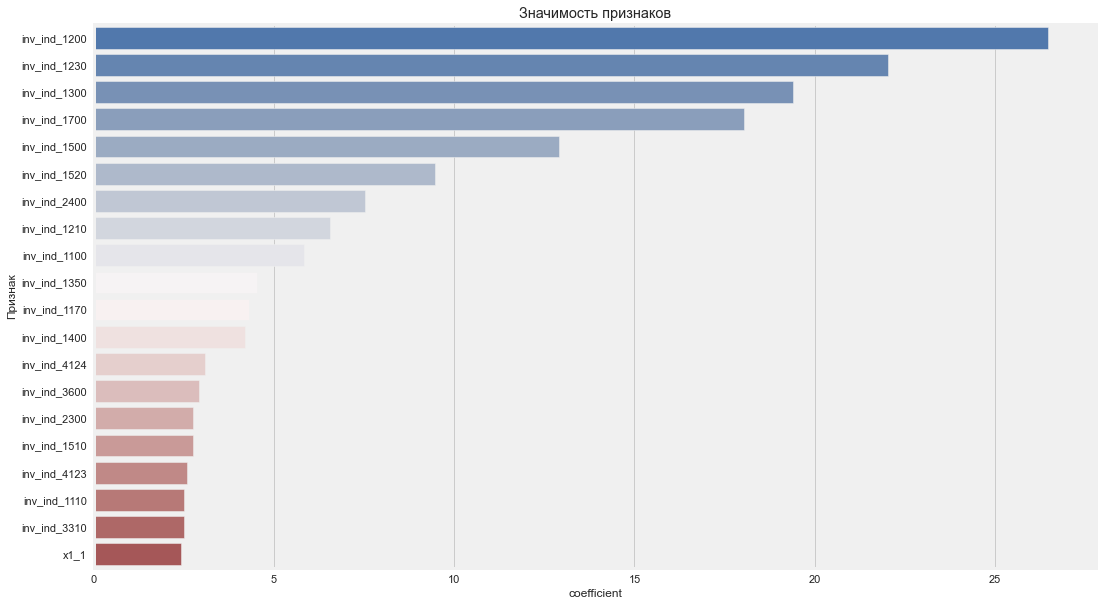

In [505]:
show_lr_Importance(lr, X.columns)

In [506]:
# По замечаниям - проверка на переобучение
y_prob = lr.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob[:, 1])

0.7413029316826969

### LGBMClassifier

In [507]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced')
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.8016424030724413

Результат еще лучше, но нас интересует не просто выйдет или нет из убытков, а срок

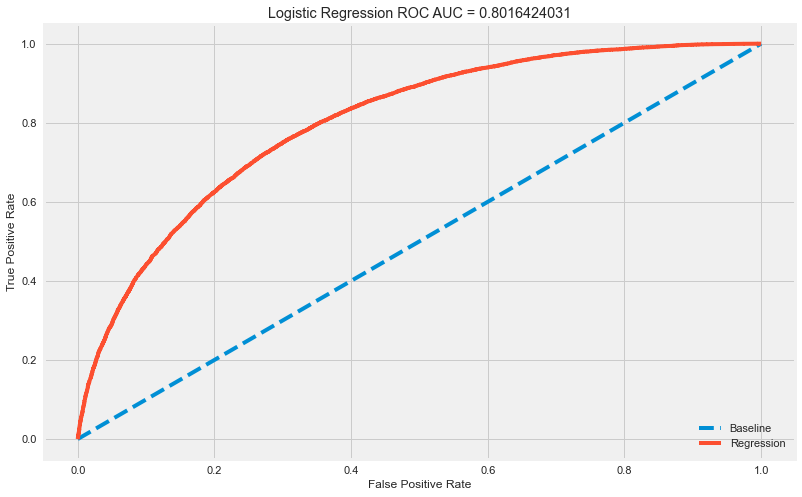

In [508]:
show_roc_auc(y_valid, y_prob[:, 1])

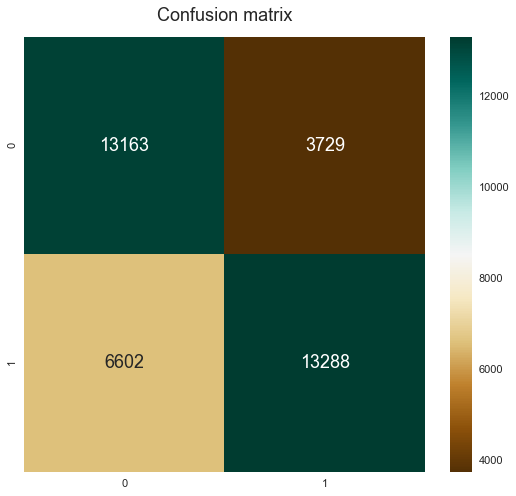

In [509]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

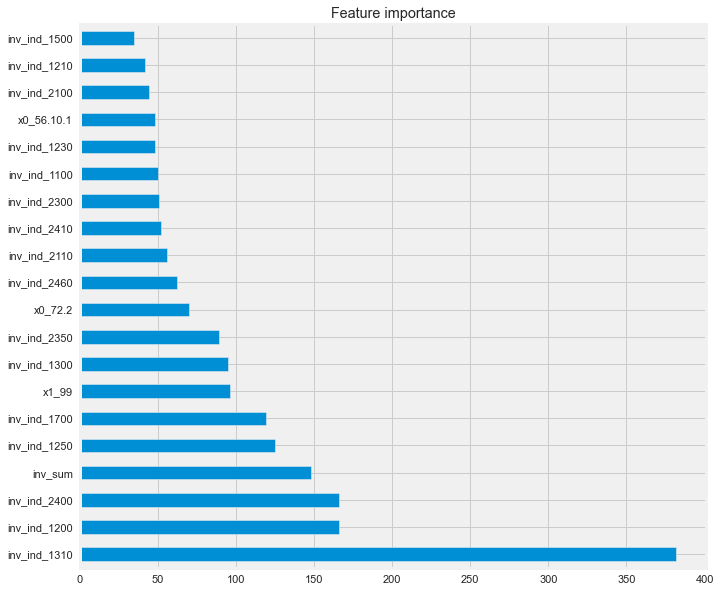

In [510]:
plot_feature_importances(model.feature_importances_, X.columns)

In [511]:
# По замечаниям - проверка на переобучение
y_prob = model.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob[:, 1])

0.8111657254053636

### Предсказание срока выхода из убытков

In [549]:
# Можно попробовать разный набор фичей, но для начала возьмем сумму инвестиций и ОКВЕД
#train_features = ['inv_sum']
train_features = ['inv_sum', 'inv_ind_1520']
# train_features = ['inv_sum', 'inv_ind_1500', 'inv_ind_1200', 'inv_ind_1300', 'inv_ind_1400']
X = pd.DataFrame([], index=work_df.index)
X[train_features] = preprocessing.StandardScaler().fit_transform(work_df[train_features])
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved', 'subject_rf']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved', 'subject_rf']]).astype(int)
# y = work_df['target'].copy()
y = work_df['target'].apply(lambda x: x if x <= 5 else -1)
X.shape, y.shape

((183907, 155), (183907,))

In [513]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((183907, 155), (183907,), (147125, 155), (147125,), (36782, 155), (36782,))

In [514]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced')
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob, multi_class='ovr', average='weighted')

0.7167029120357263

In [515]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in skf.split(X, y):
    model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced')
    model.fit(X.iloc[train_index, :], y.iloc[train_index])
    y_prob = model.predict_proba(X.iloc[test_index, :])
    print(metrics.roc_auc_score(y.iloc[test_index], y_prob, multi_class='ovr', average='weighted'))
#cross_val_score(model, X, y, cv=5, scoring='roc_auc_ovo_weighted')

0.7148166895755401
0.7183458174755262
0.7177393627924875
0.7143069474339538
0.7156697359446328


На самом деле для такого набора признаков и модели без настроенных гиперпараметров результат просто поразительный, следовательно нужно искать где
в предыдущих раскладках ошибка

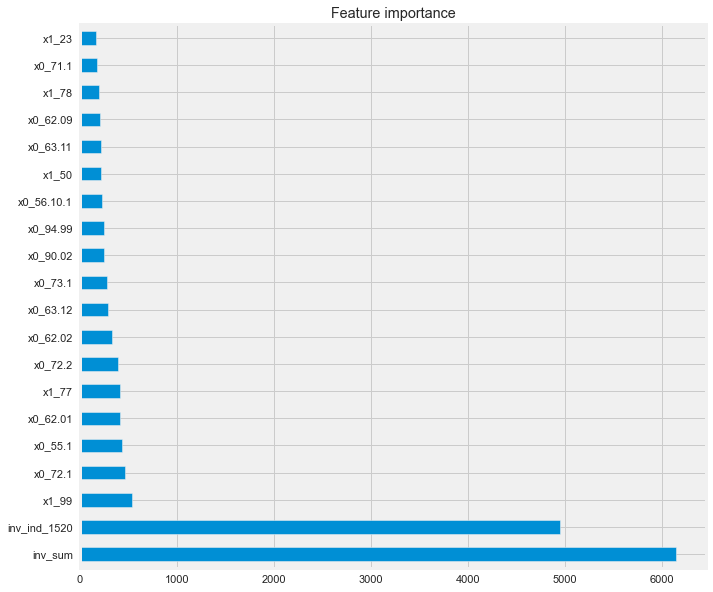

In [516]:
plot_feature_importances(model.feature_importances_, X.columns)

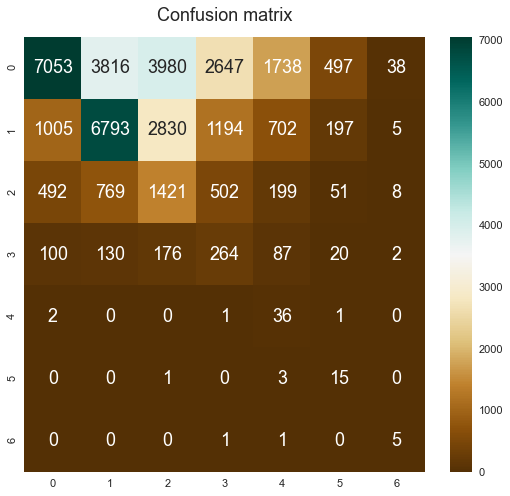

In [517]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_pred, y_valid)

In [518]:
list(zip(y_pred, y_valid))[100:110]

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (-1, -1),
 (1, 0),
 (-1, -1),
 (0, 0),
 (2, -1)]

In [519]:
# По замечаниям - проверка на переобучение
y_prob = model.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob, multi_class='ovr', average='weighted')

0.7267943961090445

In [550]:
test_data = pd.read_csv('data/test4rosstat.csv')[train_features + ['inn', 'main_okved', 'region', 'date_reg', 'target', 'year']]
test_data['subject_rf'] = test_data['region'].apply(lambda x: '77' if x == 'msk' else '78')
test_data['date_reg'] = pd.to_datetime(test_data['date_reg'])
test_data['inn'] = test_data['inn'].astype(str)
test_data.head()

,inv_sum,inv_ind_1520,inn,main_okved,region,date_reg,target,year,subject_rf
0,7.760527,2269.237837,1102068218,62.01,msk,2011-04-04,-1,2020,77
1,3.432021,0.492281,1650329732,62.01,msk,2016-04-25,4,2020,77
2,5.200892,0.000000,1655298774,62.01,msk,2014-08-12,1,2015,77
3,3.475050,5.179365,1655300448,62.09,msk,2014-09-05,1,2015,77
4,5.091586,107.699071,2310172571,62.09,msk,2013-09-09,5,2018,77


In [551]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13954 entries, 0 to 13953
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   inv_sum       13954 non-null  float64       
 1   inv_ind_1520  13954 non-null  float64       
 2   inn           13954 non-null  object        
 3   main_okved    13954 non-null  object        
 4   region        13954 non-null  object        
 5   date_reg      13954 non-null  datetime64[ns]
 6   target        13954 non-null  int64         
 7   year          13954 non-null  int64         
 8   subject_rf    13954 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 981.3+ KB


In [552]:
test2018 = test_data.loc[(test_data['date_reg'].dt.year == 2018), ['inn', 'inv_sum', 'inv_ind_1520']]
test2018.head()

,inn,inv_sum,inv_ind_1520
10,5003127685,2.990010,11.561560
14,5010055350,2.872728,11.322355
24,5027270420,0.466684,0.000000
26,5032294828,2.271689,0.063788
27,5032297321,6.688844,665.339878


In [553]:
train2018 = work_df.loc[work_df['year'] == 2018, ['inn', 'inv_sum', 'inv_ind_1520']]
train2018.head()

,inn,inv_sum,inv_ind_1520
7,1001011021,4.749581,19.519103
10,1001014689,2.484250,15.596146
11,1001014953,1.758668,2.200683
27,1001016164,5.406325,0.302993
29,1001016407,-2.529048,0.000000


In [554]:
test2018.merge(train2018, on='inn')

,inn,inv_sum_x,inv_ind_1520_x,inv_sum_y,inv_ind_1520_y
0,5003127685,2.990010,11.561560,2.990010,11.561560
1,5032294828,2.271689,0.063788,2.271689,0.063788
2,6670471060,-1.047443,0.000000,0.721327,0.000000
3,7702428167,5.481843,135.708795,5.481843,135.708795
4,7702428174,-1.653579,0.000000,-1.653579,0.000000
...,...,...,...,...,...
1769,9731016845,-1.305272,0.000000,-1.305272,0.000000
1770,9731017260,2.185873,0.924925,2.185873,0.924925
1771,9731017334,-1.835901,0.000000,-1.835901,0.000000
1772,9731019701,-1.653579,0.000000,-1.653579,0.000000


In [525]:
test_data = test_data[(test_data['date_reg'].dt.year > 2018)]
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 25 to 13953
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   inv_sum       714 non-null    float64       
 1   inv_ind_1520  714 non-null    float64       
 2   inn           714 non-null    object        
 3   main_okved    714 non-null    object        
 4   region        714 non-null    object        
 5   date_reg      714 non-null    datetime64[ns]
 6   target        714 non-null    int64         
 7   year          714 non-null    int64         
 8   subject_rf    714 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 55.8+ KB


In [526]:
X_test = test_data[train_features + ['main_okved', 'subject_rf']]
X_test[train_features] = preprocessing.StandardScaler().fit_transform(X_test[train_features])
X_test[ohe.get_feature_names()] = ohe.transform(X_test[['main_okved', 'subject_rf']]).astype(int)
X_test.drop(['main_okved', 'subject_rf'], axis=1, inplace=True)
y_test = test_data['target'].apply(lambda x: x if x <= 2 else -1)
X_test.shape, y_test.shape

((714, 155), (714,))

In [527]:
# Можно попробовать разный набор фичей, но для начала возьмем сумму инвестиций и ОКВЕД
#train_features = ['inv_sum']
train_features = ['inv_sum', 'inv_ind_1520']
# train_features = ['inv_sum', 'inv_ind_1500', 'inv_ind_1200', 'inv_ind_1300', 'inv_ind_1400']
X = pd.DataFrame([], index=work_df.index)
X[train_features] = preprocessing.StandardScaler().fit_transform(work_df[train_features])
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved', 'subject_rf']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved', 'subject_rf']]).astype(int)
y = work_df['target'].apply(lambda x: x if x <= 2 else -1)
X.shape, y.shape

((183907, 155), (183907,))

In [528]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced')
model.fit(X, y)
y_prob = model.predict_proba(X_test)
metrics.roc_auc_score(y_test, y_prob,  multi_class='ovr', average='weighted')

0.49933690545669834

In [529]:
y_test.unique(), y_prob.shape

(array([-1,  1,  0,  2]), (714, 4))

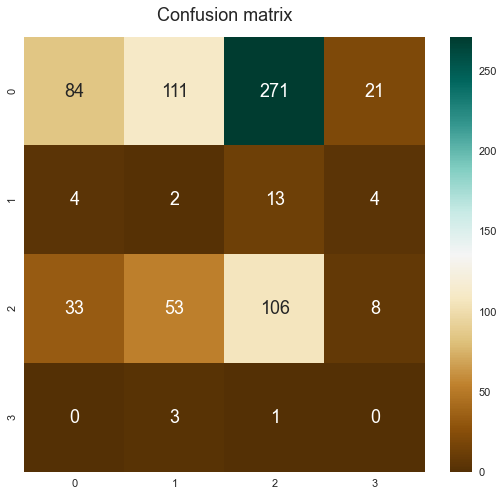

In [530]:
y_pred = model.predict(X_test)
show_confusion_matrix(y_pred, y_test)

In [531]:
y_test.value_counts()

-1    487
 1    200
 0     23
 2      4
Name: target, dtype: int64

In [532]:
# Теперь моделька
lr = LogisticRegressionCV(Cs=10, random_state=RANDOM_SEED, class_weight='balanced')
lr.fit(X, y != - 1)
y_prob = lr.predict_proba(X_test)
metrics.roc_auc_score(y_test != -1, y_prob[:, 1])

0.5230531257632363

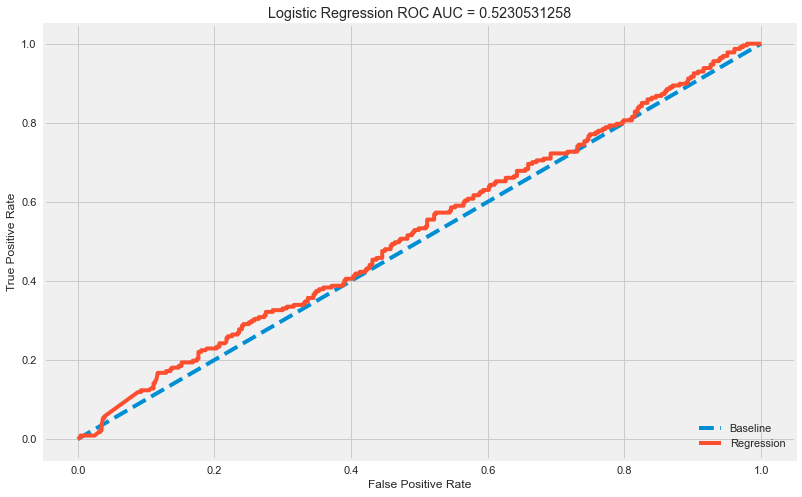

In [533]:
show_roc_auc(y_test != -1, y_prob[:, 1])

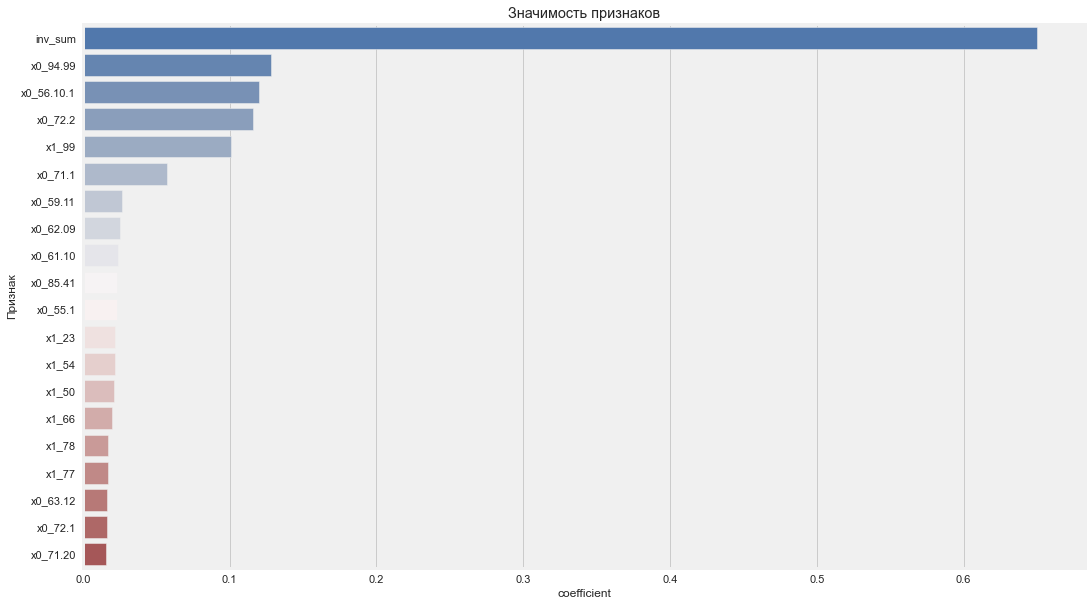

In [534]:
show_lr_Importance(lr, X.columns)

In [535]:
work_df.head()

,inn,main_okved,inv_sum,target,subject_rf,year,first_year,last_year,inv_ind_1110,inv_ind_1120,...,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400,dollar
0,1001002620,63.11,6.499417,-1,99,2015,2013,2015,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.9579
1,1001004137,56.10.1,0.548611,-1,99,2017,2017,2017,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.3529
3,1001004377,91.02,0.057466,0,99,2016,2016,2018,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0349
4,1001007610,93.2,0.458226,0,10,2016,2016,2018,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0349
5,1001009512,60.10,2.697376,0,10,2017,2017,2018,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.3529


In [536]:
train_indices = work_df['first_year'] <= 2015
test_indices = work_df['first_year'] > 2015
train_indices.sum(),  test_indices.sum()

(26900, 157007)

In [537]:
# Можно попробовать разный набор фичей, но для начала возьмем сумму инвестиций и ОКВЕД
#train_features = ['inv_sum']
train_features = ['inv_sum']
# train_features = ['inv_sum', 'inv_ind_1500', 'inv_ind_1200', 'inv_ind_1300', 'inv_ind_1400']
X = pd.DataFrame([], index=work_df.index)
X[train_features] = work_df[train_features]
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved', 'subject_rf']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved', 'subject_rf']]).astype(int)
# y = work_df['target'].copy()
y = work_df['target'].apply(lambda x: x if x <= 2 else -1)
X.shape, y.shape

((183907, 154), (183907,))

In [538]:
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((183907, 154), (183907,), (26900, 154), (26900,), (157007, 154), (157007,))

In [539]:
X_train[train_features]  = preprocessing.StandardScaler().fit_transform(X_train[train_features])
X_test[train_features]  = preprocessing.StandardScaler().fit_transform(X_test[train_features])
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((183907, 154), (183907,), (26900, 154), (26900,), (157007, 154), (157007,))

In [540]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced')
model.fit(X_test, y_test)
y_prob = model.predict_proba(X_test)
metrics.roc_auc_score(y_test, y_prob,  multi_class='ovr', average='weighted')

0.7465629531231582

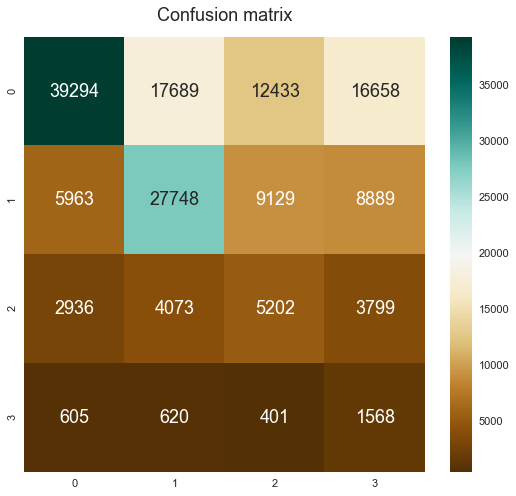

In [541]:
y_pred = model.predict(X_test)
show_confusion_matrix(y_pred, y_test)

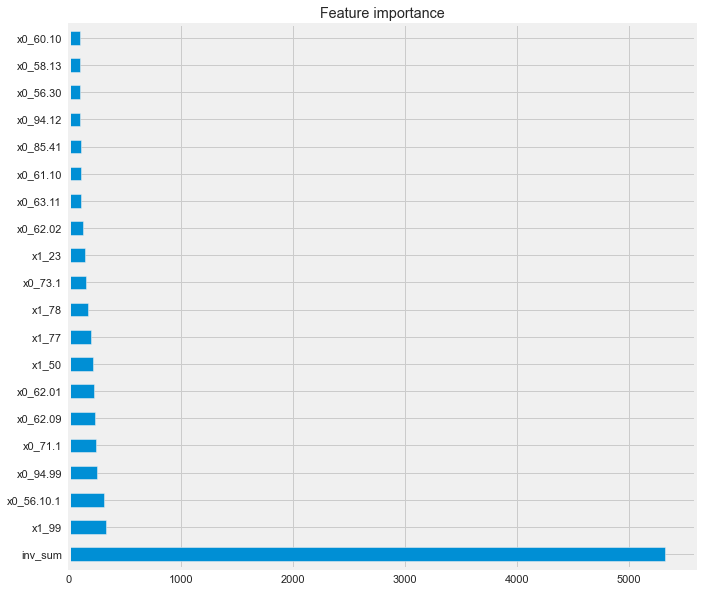

In [542]:
plot_feature_importances(model.feature_importances_, X.columns)

In [543]:
y_prob = model.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob,  multi_class='ovr', average='weighted')

0.7244141199576924